In [1]:
import pandas as pd
import requests
import ollama
import time
import os
from tqdm import tqdm
import re

In [45]:
# Load your CSV file
# df = pd.read_csv(os.path.join("data", "comments.csv"))
df = pd.read_csv('./data/manually_labelled.csv')

# Clean: keep only rows with valid post and comment
df = df.dropna(subset=["post_title", "comment_body"]).copy()
df.reset_index(drop=True, inplace=True)

# Prepare output columns
df["llm_stance"] = ""
df["llm_argument"] = ""
# df["llm_strategy"] = ""

In [46]:
def filter_content(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text.lower())

    try:
        stance_index = text.index('stance')
    except ValueError:
        stance_index = 0

    try:
        arg_index = text.index('argument')
    except ValueError:
        arg_index = 0
    # stat_index = text.index('strategy')

    if arg_index>stance_index:
        stance = text[stance_index:arg_index]
    else:
        stance = text[stance_index:]
    stance_approve = 'Disapprove' if 'disapprove' in stance else 'Approve'

    argument = text[arg_index:].split(' ')
    
    try:
        argument.remove('argument')
    except:
        pass

    argument = ' '.join(argument)
    
    # stat = text[stat_index:].split(' ')
    # stat.remove('strategy')
    # stat = ' '.join(stat)

    return stance_approve, argument#, stat

In [47]:
# LLM prompt template
def create_prompt(post, comment):
    return f"""
You are analysing political comments on news posts.

Post: "{post.strip()}"
Comment: "{comment.strip()}"

Label this comment with:
1. Stance: Whether the Comment approve or disapprove with the Post
2. Argument: The reasoning behind this stance in 20 words
Answer in this format:
Stance: ...
Argument: ...
"""

#3. Strategy: What kind of strategy does the commenter use? (e.g., emotional appeal, moral appeal, factual reasoning, economic concern) in 20 words

# Function to call Ollama locally
def query_ollama(prompt):
    url = "http://localhost:11434/api/generate"
    data = {
        "model": "gemma3:4b",
        "prompt": prompt,
        "stream": False
    }
    try:
        response = requests.post(url, json=data)
        response.raise_for_status()
        return response.json()["response"]
    except Exception as e:
        print("Error:", e)
        return None

In [48]:
# Run through the data
# for idx, row in tqdm(df.iterrows(), total=len(df), desc='Processing: '):
for idx, row in tqdm(df.iterrows(), total=len(df), dynamic_ncols=True, desc='Processing: '):
    # print(f"Processing row {idx+1}/{len(df)}...")
    prompt = create_prompt(row["post_title"], row["comment_body"])
    result = query_ollama(prompt)
    # print(result)
    if result:
        # Simple parsing (customise this if needed)
        # stance, argument, stat = filter_content(result)
        stance, argument = filter_content(result)
        # for line in result.splitlines():
        #     if line.lower().startswith("stance:"):
        #         df.at[idx, "llm_stance"] = line.split(":", 1)[1].strip()
        #     elif line.lower().startswith("argument:"):
        #         df.at[idx, "llm_argument"] = line.split(":", 1)[1].strip()
        #     elif line.lower().startswith("strategy:"):
        #         df.at[idx, "llm_strategy"] = line.split(":", 1)[1].strip()
        df.at[idx, "llm_stance"] = stance
        df.at[idx, "llm_argument"] = argument
        # df.at[idx, "llm_strategy"] = stat

    idx += 1

    time.sleep(1)  # slight delay to avoid overload

# Save results
df.to_csv("auto_labelled_comments.csv", index=False)
print("Labelling complete. Output saved to 'auto_labelled_comments.csv'.")

Processing: 100%|██████████| 100/100 [04:14<00:00,  2.55s/it]

Labelling complete. Output saved to 'auto_labelled_comments.csv'.


In [49]:
df.columns

Index(['category', 'post_date', 'post_title', 'comment_date', 'comment_votes',
       'comment_body', 'comment_stance', 'comment_argument', 'llm_stance',
       'llm_argument'],
      dtype='object')

In [50]:
df['comment_stance'] = df['comment_stance'].fillna('None')

In [52]:
df = df[df['comment_stance'] != 'none']
df['comment_stance'] = df['comment_stance'].map(str.lower)
df['llm_stance'] = df['llm_stance'].map(str.lower)
y_true, y_pred = df['comment_stance'], df['llm_stance']

print(y_true)
print(y_pred)

1     disapprove
2     disapprove
3     disapprove
4     disapprove
6     disapprove
         ...    
93       approve
96       approve
97    disapprove
98       approve
99       approve
Name: comment_stance, Length: 65, dtype: object
1     disapprove
2     disapprove
3     disapprove
4     disapprove
6     disapprove
         ...    
93    disapprove
96    disapprove
97    disapprove
98    disapprove
99    disapprove
Name: llm_stance, Length: 65, dtype: object


Accuracy Score:  0.7692307692307693


Text(45.722222222222214, 0.5, 'Predicted Labels')

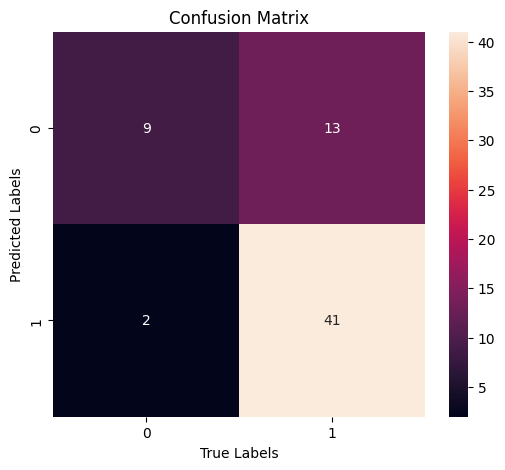

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

acc_score = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print('Accuracy Score: ', acc_score)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')